# Preliminaries 

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...

if torch.cuda.is_available():    
    device = torch.device('cuda')    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
from IPython.display import display, set_matplotlib_formats
from collections import Counter
from itertools import chain
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
! pip install transformers
from transformers import AdamW, XLNetTokenizer, XLNetModel, TFXLNetModel, XLNetLMHeadModel, XLNetConfig, XLNetForSequenceClassification
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tqdm import tqdm, trange
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation, MaxPool2D, concatenate 
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.models import Model, load_model
from keras.optimizers import Adam
import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import GRU, LSTM
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.nn import BCEWithLogitsLoss, NLLLoss
import warnings
import nltk
import torch
set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')
nltk.download('punkt')

import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Nlp Project/train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/Nlp Project/test.csv')

In [ ]:
df_test.head(2)

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...




# Data Preprocessing


In [ ]:
df_train = df_train.fillna(' ')
df_test = df_test.fillna(' ')
df_train['all'] = df_train['title'] + " " + df_train['author'] +" "+ df_train['text']
df_test['all'] = df_test['title'] + " " +df_test['author'] +" " + df_test['text']


In [ ]:
import string
import nltk
from nltk.stem import WordNetLemmatizer
import string
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
stop = stopwords.words('english')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = stopwords.words('english')
addition = ['•', '!', '"', '#', '”', '“', '$', '%', '&', "'", '–', '(', ')', '*','’', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '…']
stop_words.extend(addition)

In [ ]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
df_train['all'] = df_train['all'].apply(lambda x:' '.join(x.split()))
for i in range(0,len(df_train)):
  text=df_train["all"].iloc[i]
  text = text.lower()
  text = re.sub(r'\@\w+|\#','', text)
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
  text = text.translate(str.maketrans('', '', string.punctuation))
  result = ''.join([i for i in text if not i.isdigit()])
  tweet_tokens = nltk.word_tokenize(result)
  filtered_words = [w for w in tweet_tokens if not w in stop_words]
  lemmatizer = WordNetLemmatizer()
  lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]
  lemma_words=" ".join(lemma_words)
  df_train["all"].iloc[i]=lemma_words

In [ ]:
df_test['all'] = df_test['all'].apply(lambda x:' '.join(x.split()))
for i in range(0,len(df_test)):
  text=df_test["all"].iloc[i]
  text = text.lower()
  text = re.sub(r'\@\w+|\#','', text)
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
  text = text.translate(str.maketrans('', '', string.punctuation))
  result = ''.join([i for i in text if not i.isdigit()])
  tweet_tokens = nltk.word_tokenize(result)
  filtered_words = [w for w in tweet_tokens if not w in stop_words]
  lemmatizer = WordNetLemmatizer()
  lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]
  lemma_words=" ".join(lemma_words)
  df_test["all"].iloc[i]=lemma_words

Concatenating train and test to get all the text at one place and this can be used for further processing

In [ ]:
df = pd.concat([df_train, df_test])
df.shape

(26000, 6)

In [ ]:
df.head(2)

,id,title,author,text,label,all
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1.0,house dem aide even see comey letter jason cha...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0.0,flynn hillary clinton big woman campus breitba...


## Data Visualization

### Checking for class Imbalance

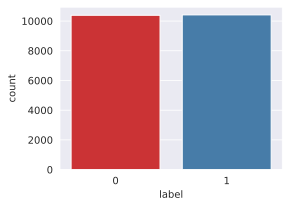

In [ ]:
sns.set_style("darkgrid")
sns.set_palette('Set1')
fig, axes=plt.subplots(figsize=(4, 3))
axes = sns.countplot(df_train.label)
fig.show()

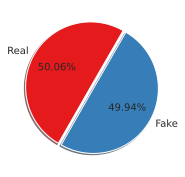

In [ ]:
fig , axes = plt.subplots(ncols=1, nrows=1, figsize=(4, 3), dpi=100)
axes.pie(df_train['label'].value_counts(), labels=['Real', 'Fake'],autopct='%1.2f%%',shadow=True,explode=(0.05, 0),startangle=60)
fig.show()

Here the class is balanced hence sampling is not required.

### Checking the distribution of the frequent words present in both the classes ie '0' -> 'reliable' , '1' -> 'unreliable.

In [ ]:
fake=[]
real=[]
for i in range(0,len(df_train)):
  label = df_train['label'].iloc[i]
  if label == 0:
    real.extend(nltk.word_tokenize(df_train['all'].iloc[i]))
  if label == 1:
    fake.extend(nltk.word_tokenize(df_train['all'].iloc[i]))

In [ ]:
print(len(real))
print(len(fake))

5153179
3820033


In [ ]:
def word_frequency(wordlist , label):
  count = dict(Counter(wordlist))
  word_freq_df = pd.DataFrame(count.values() ,index = count.keys() , columns = ['Word_Frequency'])
  word_freq_df.index = word_freq_df.index.set_names(label)
  word_freq_df = word_freq_df.sort_values(by = 'Word_Frequency', ascending = False, axis=0)[:20]
  display(word_freq_df)
  

word_frequency(real,'Real')  
word_frequency(fake ,'Fake')

,Word_Frequency
Real,
said,68223
mr,64575
—,39223
trump,38303
new,26539
would,22869
one,22648
people,20037
president,17042


,Word_Frequency
Fake,
us,20780
trump,20574
clinton,19419
people,16497
one,15575
would,14545
hillary,13469
said,11876
new,10843


### Checking the lenght of the news article for different class label.

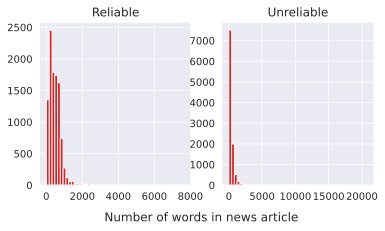

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(6,3))
text_len=df_train[df_train.label==0]['all'].str.split().map(lambda x: len(x))
ax1.hist(text_len, bins = 50)
ax1.set_title('Reliable')
text_len=df_train[df_train.label==1]['all'].str.split().map(lambda x: len(x))
ax2.hist(text_len, bins = 50)
ax2.set_title('Unreliable')
fig.suptitle('Number of words in news article', y=0)
fig.show()

## Word Cloud

In [ ]:
!pip install wordcloud

### Train

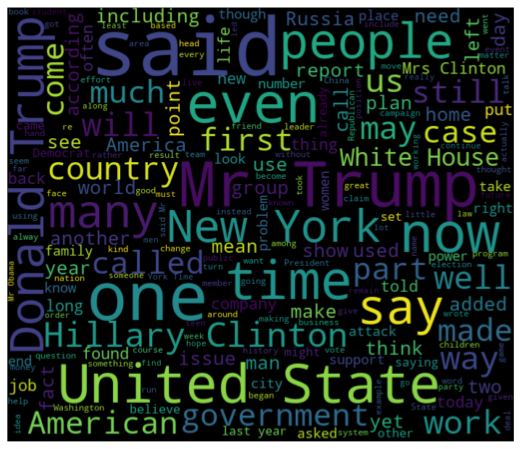

In [ ]:
from wordcloud import WordCloud
all = ' '.join([text for text in df_train['text']]) 
wordcloud = WordCloud(width=700, height=600, random_state=25, max_font_size=110).generate(all) 
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

### Test

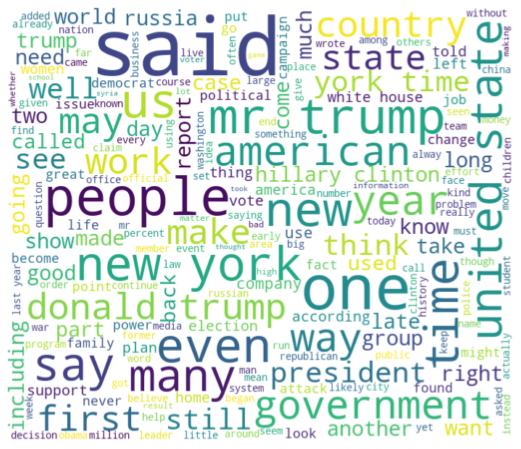

In [ ]:
from wordcloud import WordCloud
all = ' '.join([text for text in df_test['all']]) 
wordcloud = WordCloud(width=700, height=600,background_color = "white", random_state=25, max_font_size=110).generate(all) 
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()


# Word2Vec


In [ ]:
maxlen = 1000

corpus = [article.split() for article in df['all']]
w2v_model = gensim.models.Word2Vec(sentences = corpus, 
                                   size = 200, 
                                   window = 2, 
                                   min_count = 1)

train_text = [article.split() for article in df_train['all']]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
tokenized_train = tokenizer.texts_to_sequences(train_text)
word_index = tokenizer.word_index
print('Size of vocabulary: ', len(word_index))

tokenized_train_padded = pad_sequences(tokenized_train , maxlen=maxlen) #padding the sentences having size less than 10000

Size of vocabulary:  200322


In [ ]:
print(word_index) 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Here we generate a matrix which will contain the weights of the embedding layer of the model. The function create_embedding returns a matrix with a row per word, and each row is the embedding vector associated with that word.

Matrix size = size of the vocab + 1 , this +1 is to deal with the words the corpus have never seen

In [ ]:
def create_embeddings(model, vocab): #here we will convert word2vec to keras weights
    size = len(vocab) + 1
    matrix = np.zeros((size, 200))
    for word, index in vocab.items():
        matrix[index] = model[word]
    return matrix

embedding_vectors = create_embeddings(w2v_model, word_index)

In [ ]:
print('Size of embedding: ' , len(embedding_vectors))
embedding_vectors

Size of embedding:  200323


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.27641177e-01,  6.94503903e-01, -1.41766262e+00, ...,
         2.86614358e-01, -3.90630394e-01, -9.19950366e-01],
       [ 1.67468458e-01,  1.60806194e-01, -2.67094445e+00, ...,
         3.99257928e-01,  3.87063295e-01, -1.17624199e+00],
       ...,
       [ 5.71865821e-04,  1.05619002e-02,  9.69064329e-03, ...,
         8.27718992e-04, -2.53377040e-03, -1.90159725e-03],
       [ 2.55781855e-03, -1.03730727e-02,  1.12094320e-02, ...,
        -1.28031417e-03,  2.32728049e-02, -1.54129253e-03],
       [-3.61056961e-02,  5.15252398e-03,  3.99410054e-02, ...,
         1.50980903e-02,  1.35360714e-02,  2.51360815e-02]])

In [7]:
y_train = list(df_train['label'])
y_train = np.array(y_train)
y_train

array([1, 0, 1, ..., 0, 1, 1])

# Training the model

### Bi-LSTM + CNN and CNN + Bi-LSTM

In [ ]:
max_len = 1000
embed_size = 200
size = len(word_index) + 1

In [ ]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (max_len,))
    x = Embedding(size, embed_size, weights = [embedding_vectors], trainable = False)(inp)
    x1 = SpatialDropout1D(dr)(x)

    x_cnn = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu')(x1)
    x_cnn = BatchNormalization()(x1)
    x_cnn = MaxPooling1D(pool_size=2)(x1)
    x_cnn = SpatialDropout1D(0.25)(x1)
    x1 = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x_cnn)
    avg_pool1_cnn = GlobalAveragePooling1D()(x1)
    max_pool1_cnn = GlobalMaxPooling1D()(x1)
    
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    x_lstm = BatchNormalization()(x1)
    x_lstm = MaxPooling1D(pool_size=2)(x1)
    x_lstm = SpatialDropout1D(0.25)(x1)
    x2 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x2)
    max_pool1_lstm = GlobalMaxPooling1D()(x2)
    
    
    x = concatenate([avg_pool1_cnn, max_pool1_cnn, avg_pool1_lstm, max_pool1_lstm])
    x = BatchNormalization()(x)
    x = Dropout(0.2)(Dense(128,activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(0.2)(Dense(100,activation='relu') (x))
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    return model

In [ ]:
!pip install -q pyyaml h5py 

In [ ]:
path = "training/cp-{epoch:d}.ckpt"
dir = os.path.dirname(path)

batch_size = 100

callback = tf.keras.callbacks.ModelCheckpoint(filepath=path, verbose=1, save_weights_only=True, save_freq=batch_size)


model = build_model(lr = 1e-4, lr_d = 0, units = 128, dr = 0.5)
model.summary()

model.save_weights(path.format(epoch=0))

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1000, 200)    40064600    input_8[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_11 (SpatialDr (None, 1000, 200)    0           embedding_7[0][0]                
__________________________________________________________________________________________________
spatial_dropout1d_12 (SpatialDr (None, 1000, 200)    0           spatial_dropout1d_11[0][0]       
_______________________________________________________________________________________

In [ ]:
history = model.fit(tokenized_train_padded, y_train, validation_split=0.2, epochs=30, batch_size = 32, verbose = 1 ,callbacks=[callback])

Epoch 1/30
 99/520 [====>.........................] - ETA: 38s - loss: 0.7229 - accuracy: 0.5682
Epoch 00001: saving model to training/cp-1.ckpt
199/520 [==========>...................] - ETA: 29s - loss: 0.6747 - accuracy: 0.6090
Epoch 00001: saving model to training/cp-1.ckpt
299/520 [================>.............] - ETA: 20s - loss: 0.6419 - accuracy: 0.6353
Epoch 00001: saving model to training/cp-1.ckpt
399/520 [======================>.......] - ETA: 11s - loss: 0.6163 - accuracy: 0.6570
Epoch 00001: saving model to training/cp-1.ckpt
499/520 [===========================>..] - ETA: 1s - loss: 0.5948 - accuracy: 0.6755
Epoch 00001: saving model to training/cp-1.ckpt
520/520 [==============================] - 54s 104ms/step - loss: 0.5903 - accuracy: 0.6789 - val_loss: 0.3769 - val_accuracy: 0.8207
Epoch 2/30
 79/520 [===>..........................] - ETA: 40s - loss: 0.4679 - accuracy: 0.7670
Epoch 00002: saving model to training/cp-2.ckpt
179/520 [=========>....................] 

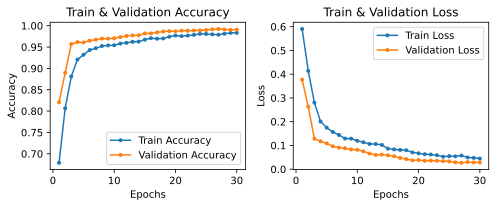

In [ ]:
def plot_loss_epochs(history):
    epochs = np.arange(1,len(history.history['accuracy']) + 1,1)
    train_accuracy = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    fig , ax = plt.subplots(1,2, figsize=(7,3))
    ax[0].plot(epochs , train_accuracy , '.-' , label = 'Train Accuracy')
    ax[0].plot(epochs , val_acc , '.-' , label = 'Validation Accuracy')
    ax[0].set_title('Train & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , '.-' , label = 'Train Loss')
    ax[1].plot(epochs , val_loss , '.-' , label = 'Validation Loss')
    ax[1].set_title('Train & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    fig.tight_layout()
    fig.show()
    
plot_loss_epochs(history)

**Save the model**

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from google.colab import files

files.download('model.json')
files.download('model.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.fit(tokenized_train_padded, y_train, epochs=20, batch_size = 15, verbose = 0)

# Predicting the label on the test set



In [ ]:
test_text = [article.split() for article in df_test['all']]
tokenized_test = tokenizer.texts_to_sequences(test_text)
tokenized_test_padded = pad_sequences(tokenized_test, maxlen=maxlen)
predict = (model.predict(tokenized_test_padded)> 0.5).astype("int32")

In [ ]:
print(predict)

[[0]
 [1]
 [1]
 ...
 [0]
 [1]
 [0]]


##Creating Dataframe for Submission

In [ ]:
submit=pd.DataFrame()
submit['id']= df_test['id'] 
submit['label'] = predict

In [ ]:
submit.head(2)

,id,label
0,20800,0
1,20801,1


In [ ]:
submit.to_csv("submit.csv" , index=False)

In [4]:
submit = pd.read_csv('/content/gdrive/MyDrive/Nlp Project/submit.csv')

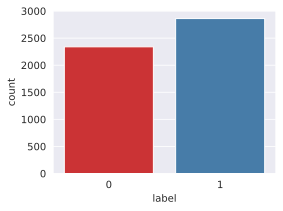

In [5]:
sns.set_style("darkgrid")
sns.set_palette('Set1')
fig, axes=plt.subplots(figsize=(4, 3))
axes = sns.countplot(submit.label)
fig.show()

In [9]:
pred = list(submit['label'])

In [ ]:
f1_score(y_t, pred, average="binary")